In [380]:
import random
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Set constraints
## Land boundry

In [381]:
min_house_width = 6
max_house_width = 18

min_house_depth = 8
max_house_depth = 25

# house_width = random.randint(min_house_width, max_house_width)
# house_depth = random.randint(min_house_depth, max_house_depth)

# set manually for now
house_width = 10
house_depth = 20

house_land = Polygon([(0, 0), (house_width, 0), (house_width, house_depth), (0, house_depth)])

## Rooms size range

In [382]:
# Define room types (type, min_width, max_width, min_depth, max_depth)
rooms_range = [
    ("Living Room", 3, 6, 3, 6),         
    ("Master Bedroom", 3, 6, 3, 6),     
    ("Bedroom", 3, 4.5, 3, 4.5),        
    ("Kitchen", 2, 4, 2, 4),            
    ("Bathroom", 2, 4, 2, 5),           
    ("Hallway", 1, 1.5, 2, 10),
    ("Balcony", 1, 2, 2, 8),
    ("Dining Room", 3, 5, 3, 5),  
]

granularity = 0.5

## Components size range
**window & door**

In [383]:
min_window_width = 0.5
max_window_width = 1.5

min_door_width = 0.5
max_door_width = 1.5


# Feasibility check Function(s)

In [384]:
def is_valid_placement(rect, cluster, house_land):
    # check if the rectangle is within the house land
    if not house_land.contains(rect):
        return False
    
    # check if the rectangle attaches to the cluster, neither overlap nor separate
    if cluster is None:
        return True
    elif cluster.touches(rect):
        touch_part = cluster.intersection(rect)
        # not just a point
        if touch_part.geom_type in ["LineString", "MultiLineString"]:
            return True
        else:
            return False
    else:
        return False

# Generate!

In [385]:
def generate_house(house_land, rooms_range):
    placed_rooms = []
    cluster = None

    for room_type, min_width, max_width, min_depth, max_depth in rooms_range:
        placed = False

        while not placed:    
            width = random.uniform(min_width, max_width)
            depth = random.uniform(min_depth, max_depth)
            
            if not placed_rooms:
                # place the first room
                x = round(random.uniform(0, house_width - width)/granularity) * granularity
                y = round(random.uniform(0, house_depth - depth)/granularity) * granularity
            else:
                # Add new room adjacent to an existing room
                base_room = random.choice(placed_rooms)
                coords = list(base_room.exterior.coords)
                bottom_left = min(coords, key=lambda point: (point[0], point[1]))
                bottom_right = max(coords, key=lambda point: (point[0], -point[1]))
                top_right = max(coords, key=lambda point: (point[0], point[1]))
                top_left = min(coords, key=lambda point: (-point[0], point[1]))

                direction = random.choice(["left", "right", "up", "down"])
                if direction == "left":
                    # top or bottom
                    random_int = random.randint(0, 1)
                    if random_int == 0:
                        x = bottom_left[0] - width
                        y = bottom_left[1]
                    else:
                        x = top_left[0] - width
                        y = top_left[1] - depth
                elif direction == "right":
                    # top or bottom
                    random_int = random.randint(0, 1)
                    if random_int == 0:
                        x = bottom_right[0]
                        y = bottom_right[1]
                    else:
                        x = top_right[0]
                        y = top_right[1] - depth
                elif direction == "up":
                    # left or right
                    random_int = random.randint(0, 1)
                    if random_int == 0:
                        x = top_left[0]
                        y = top_left[1]
                    else:
                        x = top_right[0] - width
                        y = top_right[1]
                elif direction == "down":
                    # left or right
                    random_int = random.randint(0, 1)
                    if random_int == 0:
                        x = bottom_left[0]
                        y = bottom_left[1] - depth
                    else:
                        x = bottom_right[0] - width
                        y = bottom_right[1] - depth
                    

            new_polygon = Polygon([(x, y), (x + width, y), (x + width, y + depth), (x, y + depth)])

            if is_valid_placement(new_polygon, cluster, house_land):
                placed_rooms.append(new_polygon)
                if cluster is None:
                    cluster = new_polygon
                else:
                    cluster = cluster.union(new_polygon)
                placed = True
                
            
    return placed_rooms

# Draw house function

In [386]:
def draw_house_cluster(rooms, house_land):
    plt.figure(figsize=(10, 6)) 
    x, y = house_land.exterior.xy
    plt.plot(x, y, color="grey")
    for i, room in enumerate(rooms):
        x, y = room.exterior.xy
        plt.fill(x, y, alpha=0.1)
        plt.plot(x, y)
        plt.text(room.centroid.x, room.centroid.y, f"R{i+1}", ha="center", va="center")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.grid(True, linestyle='--', alpha=0.1)
    plt.show()

# Display the result

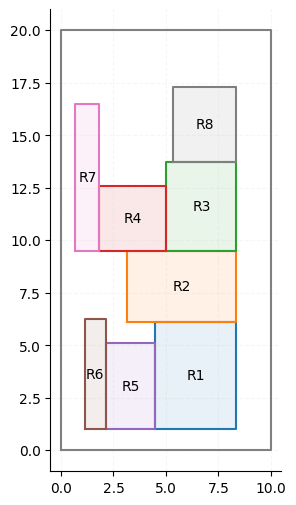

In [387]:
house_example = generate_house(house_land, rooms_range)
draw_house_cluster(house_example, house_land)